In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

Plan of attack:
- extract infomation from time:
    - Month
    - Day
    - Coloumn for day or night, or maybe some kind of variable regarding timepoint during daylight hours 
- employ machine learning models
    - I want to particulary focus on hyperparameter tuning, random forests and gradient boosting

**Random Forests**
Random forests use a number of independent trees trained on subsets of the data to turn smaller weaker trees into a potentailly stronger model.

**Gradient boosted trees**
Gradient boosting uses multiple dependent trees. Each subsequent tree places more emphasis, or weighting, on predicting the rows that were poorly predicted by the previous tree. If the previous tree or set of trees predicts a row accuratly, future trees place less emphasis on predicting this row. In this way gradient boosting trees are grown, that learn from the subsequent trees. We need to be careful not to overfit the training data, which is done by added a form of penalty to the learning trees. This is known as a learning rate.

The dataset includes observations of:

- Solar Irradiance (W/m2)
- Temperature (°F)
- Barometric Pressure (Hg)
- Humidity (%)
- Wind Direction (°)
- Wind Speed (mph)
- Sun Rise/Set Time

Load in the data and investigate the variables

In [2]:
df = pd.read_csv('SolarPrediction.csv')

In [3]:
df.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


Check for null values and feature type

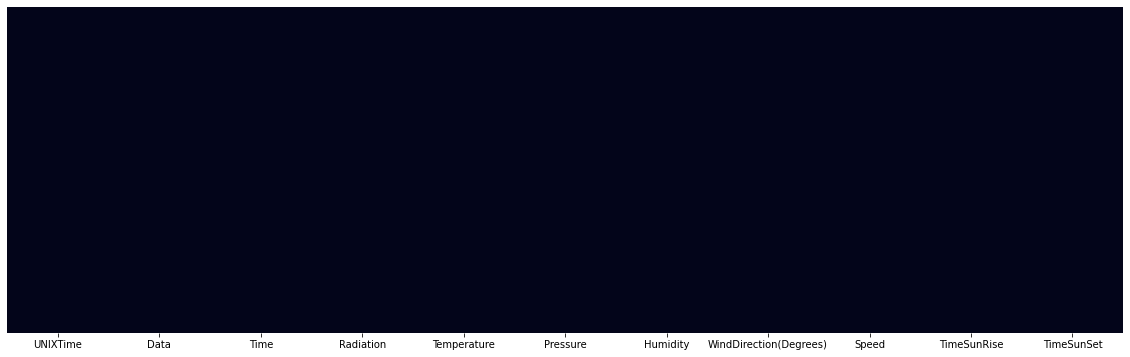

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


Lets begin with some simple intial feature engineering for the time variable

In [6]:
df['date'] = pd.to_datetime(df['Data'],errors='coerce').dt.date
df['Time'] = pd.to_datetime(df['Time'],errors='coerce').dt.time
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'],errors='coerce').dt.time
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'],errors='coerce').dt.time


In [7]:
df.drop(['UNIXTime','Data'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    32686 non-null  object 
 1   Radiation               32686 non-null  float64
 2   Temperature             32686 non-null  int64  
 3   Pressure                32686 non-null  float64
 4   Humidity                32686 non-null  int64  
 5   WindDirection(Degrees)  32686 non-null  float64
 6   Speed                   32686 non-null  float64
 7   TimeSunRise             32686 non-null  object 
 8   TimeSunSet              32686 non-null  object 
 9   date                    32686 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 2.5+ MB


In [8]:
df['Month'] = df.date.apply(lambda x : x.month)
df['Day'] = df.date.apply(lambda x : x.day)
df['Year'] = df.date.apply(lambda x : x.year)
df['time_in_secs'] = df.Time.apply(lambda x : x.hour*60*60 +x.minute*60 +x.second)
df['TimeSunSet_insec'] = df.TimeSunSet.apply(lambda x : x.hour*60*60 +x.minute*60 +x.second)
df['TimeSunRise_insec'] = df.TimeSunRise.apply(lambda x : x.hour*60*60 +x.minute*60 +x.second)

In [9]:
df.head()

,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,date,Month,Day,Year,time_in_secs,TimeSunSet_insec,TimeSunRise_insec
0,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-29,9,29,2016,86126,65580,22380
1,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-29,9,29,2016,85823,65580,22380
2,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-29,9,29,2016,85526,65580,22380
3,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-29,9,29,2016,85221,65580,22380
4,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-29,9,29,2016,84924,65580,22380


In [10]:
df['time_to_sunsent'] = df['time_in_secs'] - df['TimeSunSet_insec']
df['time_to_sunrise'] = df['time_in_secs'] - df['TimeSunRise_insec'] 

In [11]:
def percent_during_day(df):
    if (df['time_in_secs'] > df['TimeSunRise_insec']) & (df['time_in_secs'] < df['TimeSunSet_insec']):
        return (df['time_in_secs'] - df['TimeSunRise_insec']) / (df['TimeSunSet_insec'] - df['TimeSunRise_insec'])
    else:
        return 0    

In [12]:
df['Fraction_during_daylight'] = df.apply(percent_during_day,axis=1)

In [13]:
df_clean = df.drop(['Time','TimeSunRise', 'TimeSunSet','Year', 'date',],axis = 1)
df_clean.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,time_in_secs,TimeSunSet_insec,TimeSunRise_insec,time_to_sunsent,time_to_sunrise,Fraction_during_daylight
0,1.21,48,30.46,59,177.39,5.62,9,29,86126,65580,22380,20546,63746,0.0
1,1.21,48,30.46,58,176.78,3.37,9,29,85823,65580,22380,20243,63443,0.0
2,1.23,48,30.46,57,158.75,3.37,9,29,85526,65580,22380,19946,63146,0.0
3,1.21,48,30.46,60,137.71,3.37,9,29,85221,65580,22380,19641,62841,0.0
4,1.17,48,30.46,62,104.95,5.62,9,29,84924,65580,22380,19344,62544,0.0


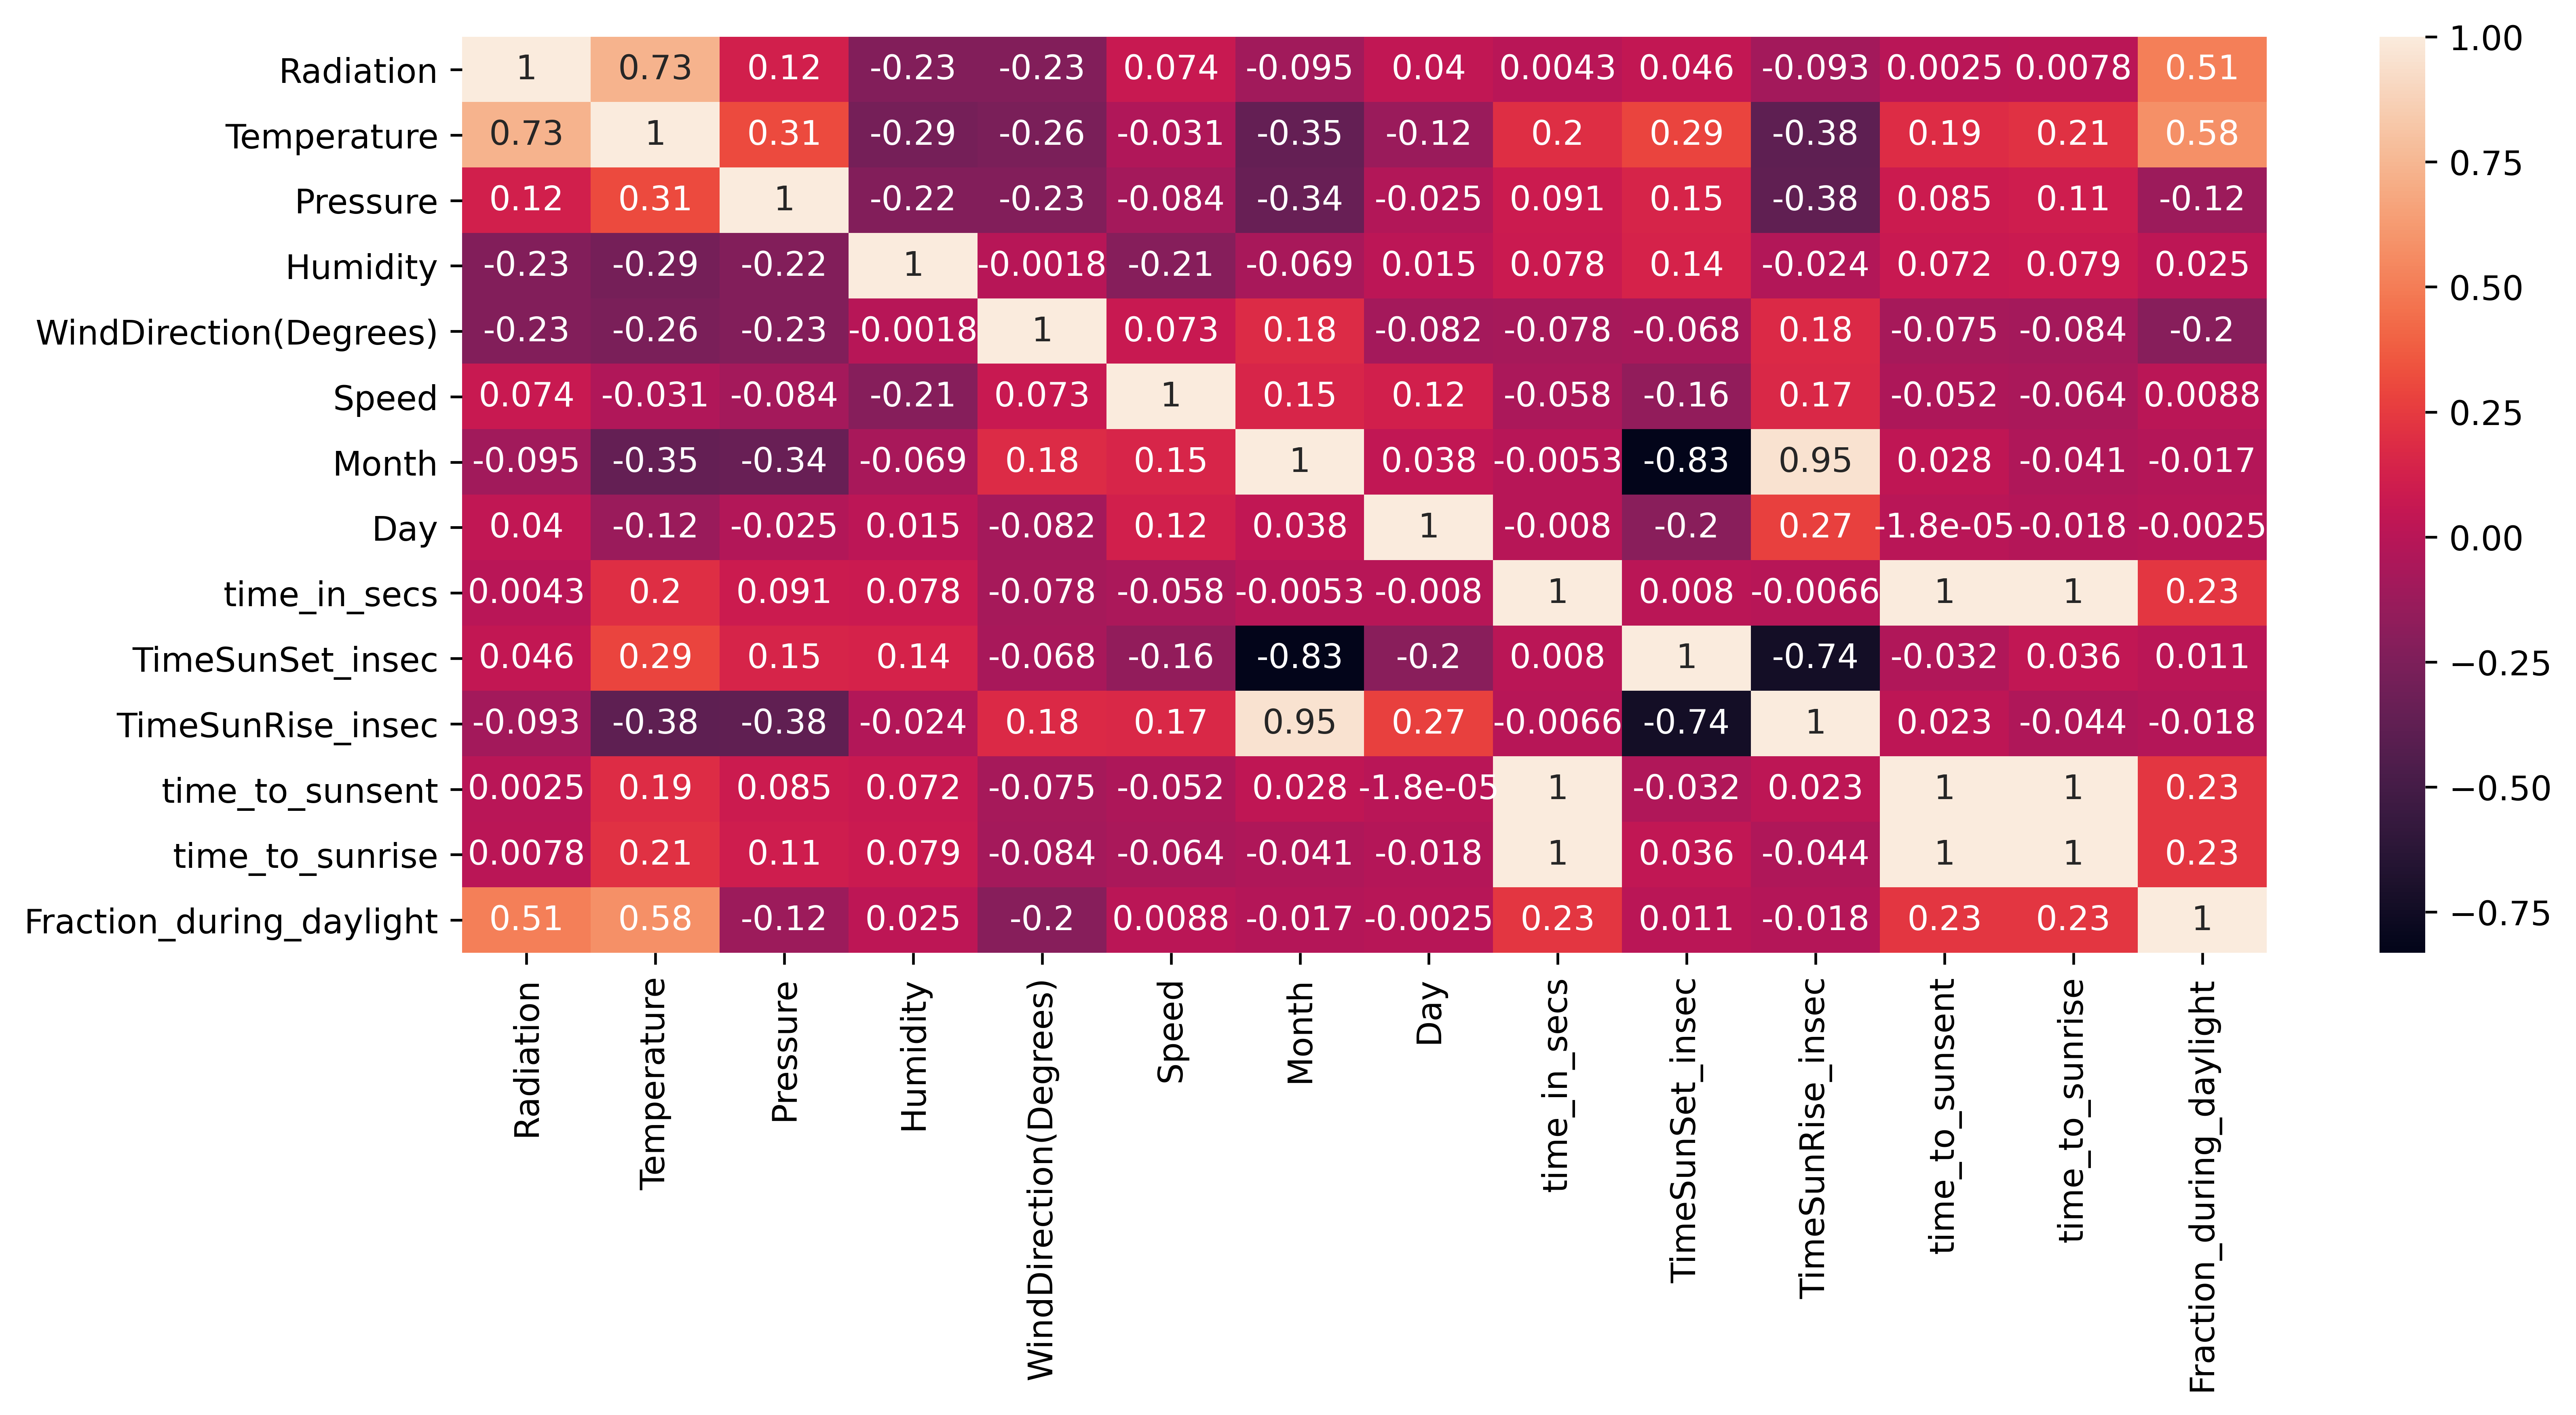

In [14]:
plt.figure(figsize = (12,5),dpi=600)
sns.heatmap(df_clean.corr(),annot=True)

Not really suprising that the fraction during daylight correlates to Radiation.

**Now that I have finished feature engineering lets get on with the model building.**

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
feats = ['Temperature', 'Pressure', 'Humidity',
       'WindDirection(Degrees)', 'Speed', 'Month', 'Day', 'time_in_secs',
       'TimeSunSet_insec', 'TimeSunRise_insec', 'time_to_sunsent',
       'time_to_sunrise', 'Fraction_during_daylight']

In [17]:
X = df[feats].values
y = df['Radiation'].values

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

I first want to try with a simple decision tree

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

In [21]:
param_dist = {'max_depth': np.arange(1,20),
             'max_features':['auto', 'sqrt','log2']}
clf = RandomizedSearchCV(DecisionTreeRegressor(), param_dist,cv=10, random_state=42)

In [22]:
clf.fit(X_train,y_train)
clf.best_params_

{'max_features': 'auto', 'max_depth': 11}

Text(0, 0.5, 'Y pred')

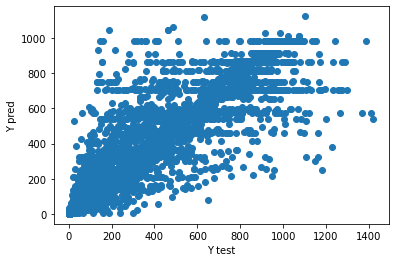

In [23]:
best_tree = DecisionTreeRegressor(max_features= 'auto', max_depth= 11)
best_tree.fit(X_train,y_train)
plt.scatter(y_test,best_tree.predict(X_test))
plt.xlabel('Y test')
plt.ylabel('Y pred')

In [24]:
best_tree.score(X_test, y_test)

0.900148979732444

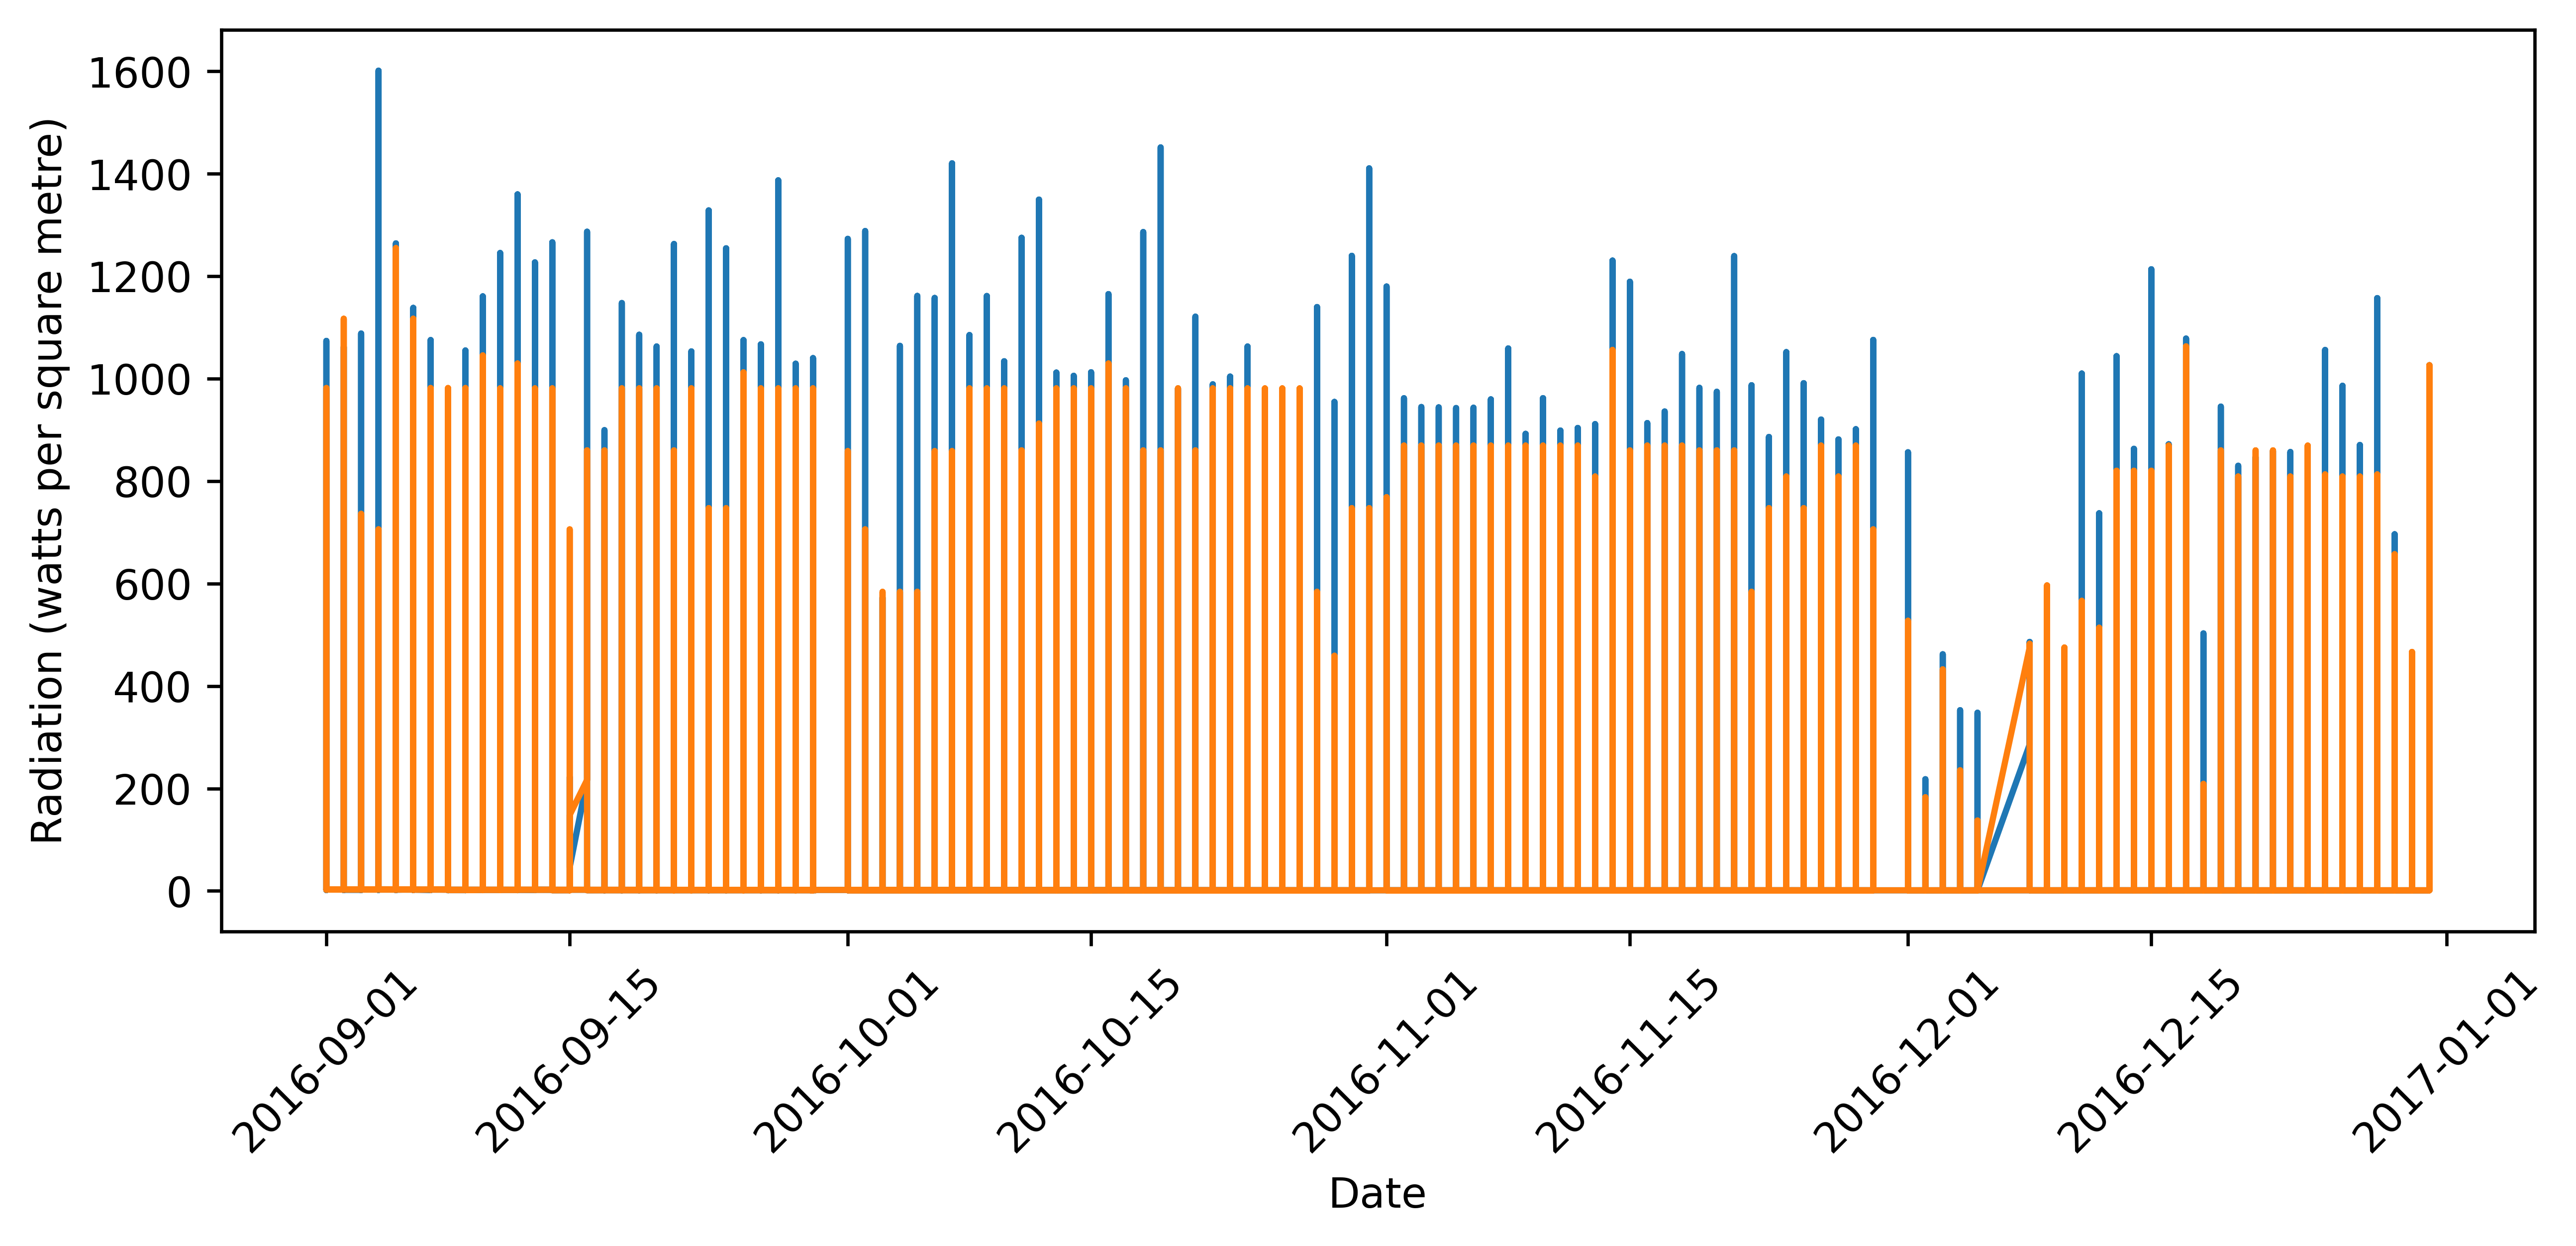

In [25]:
plt.figure(figsize=(10,4),dpi=600)
plt.plot(df.date,df.Radiation)
plt.plot(df.date,best_tree.predict(scaler.transform(X)))
plt.ylabel('Radiation (watts per square metre)')
plt.xlabel('Date')
_ = plt.xticks(rotation=45)

We can see that although the simple tree picks out the big dip around the start of December, it doesn't do a great job predicting values higher than 800 watts per metre squared. This is because a regression decision tree can only predict discrete values.

Lets try a random forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [116]:
RFR = RandomForestRegressor()
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# number of features at every split
max_features = ['auto', 'sqrt']
# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 5)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features' : max_features,
 'max_depth': max_depth
 }
# Random search of parameters
RFR_random = RandomizedSearchCV(estimator = RFR, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=2,n_jobs=-1)
# Fit the model
RFR_random.fit(X_train, y_train)
# print results
print(RFR_random.best_params_)

C:\Users\Louis\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 25.7min finished


{'n_estimators': 1550, 'max_features': 'sqrt', 'max_depth': 100}


Results from random gridsearch are as follows: {'n_estimators': 1550, 'max_features': 'sqrt', 'max_depth': 100}

In [28]:
Best_RFR = RandomForestRegressor(n_estimators=1550, max_depth=100, max_features='sqrt')
Best_RFR.fit(X_train,y_train)
Best_RFR.score(X_test, y_test)


0.9380156349125935

The random forest with the best features does a far better job of predicting the data (R^2 is 0.93 for the random forest compared with 0.90 for the simple tree)

In [29]:
best_RF_pred_y = Best_RFR.predict(scaler.transform(X))

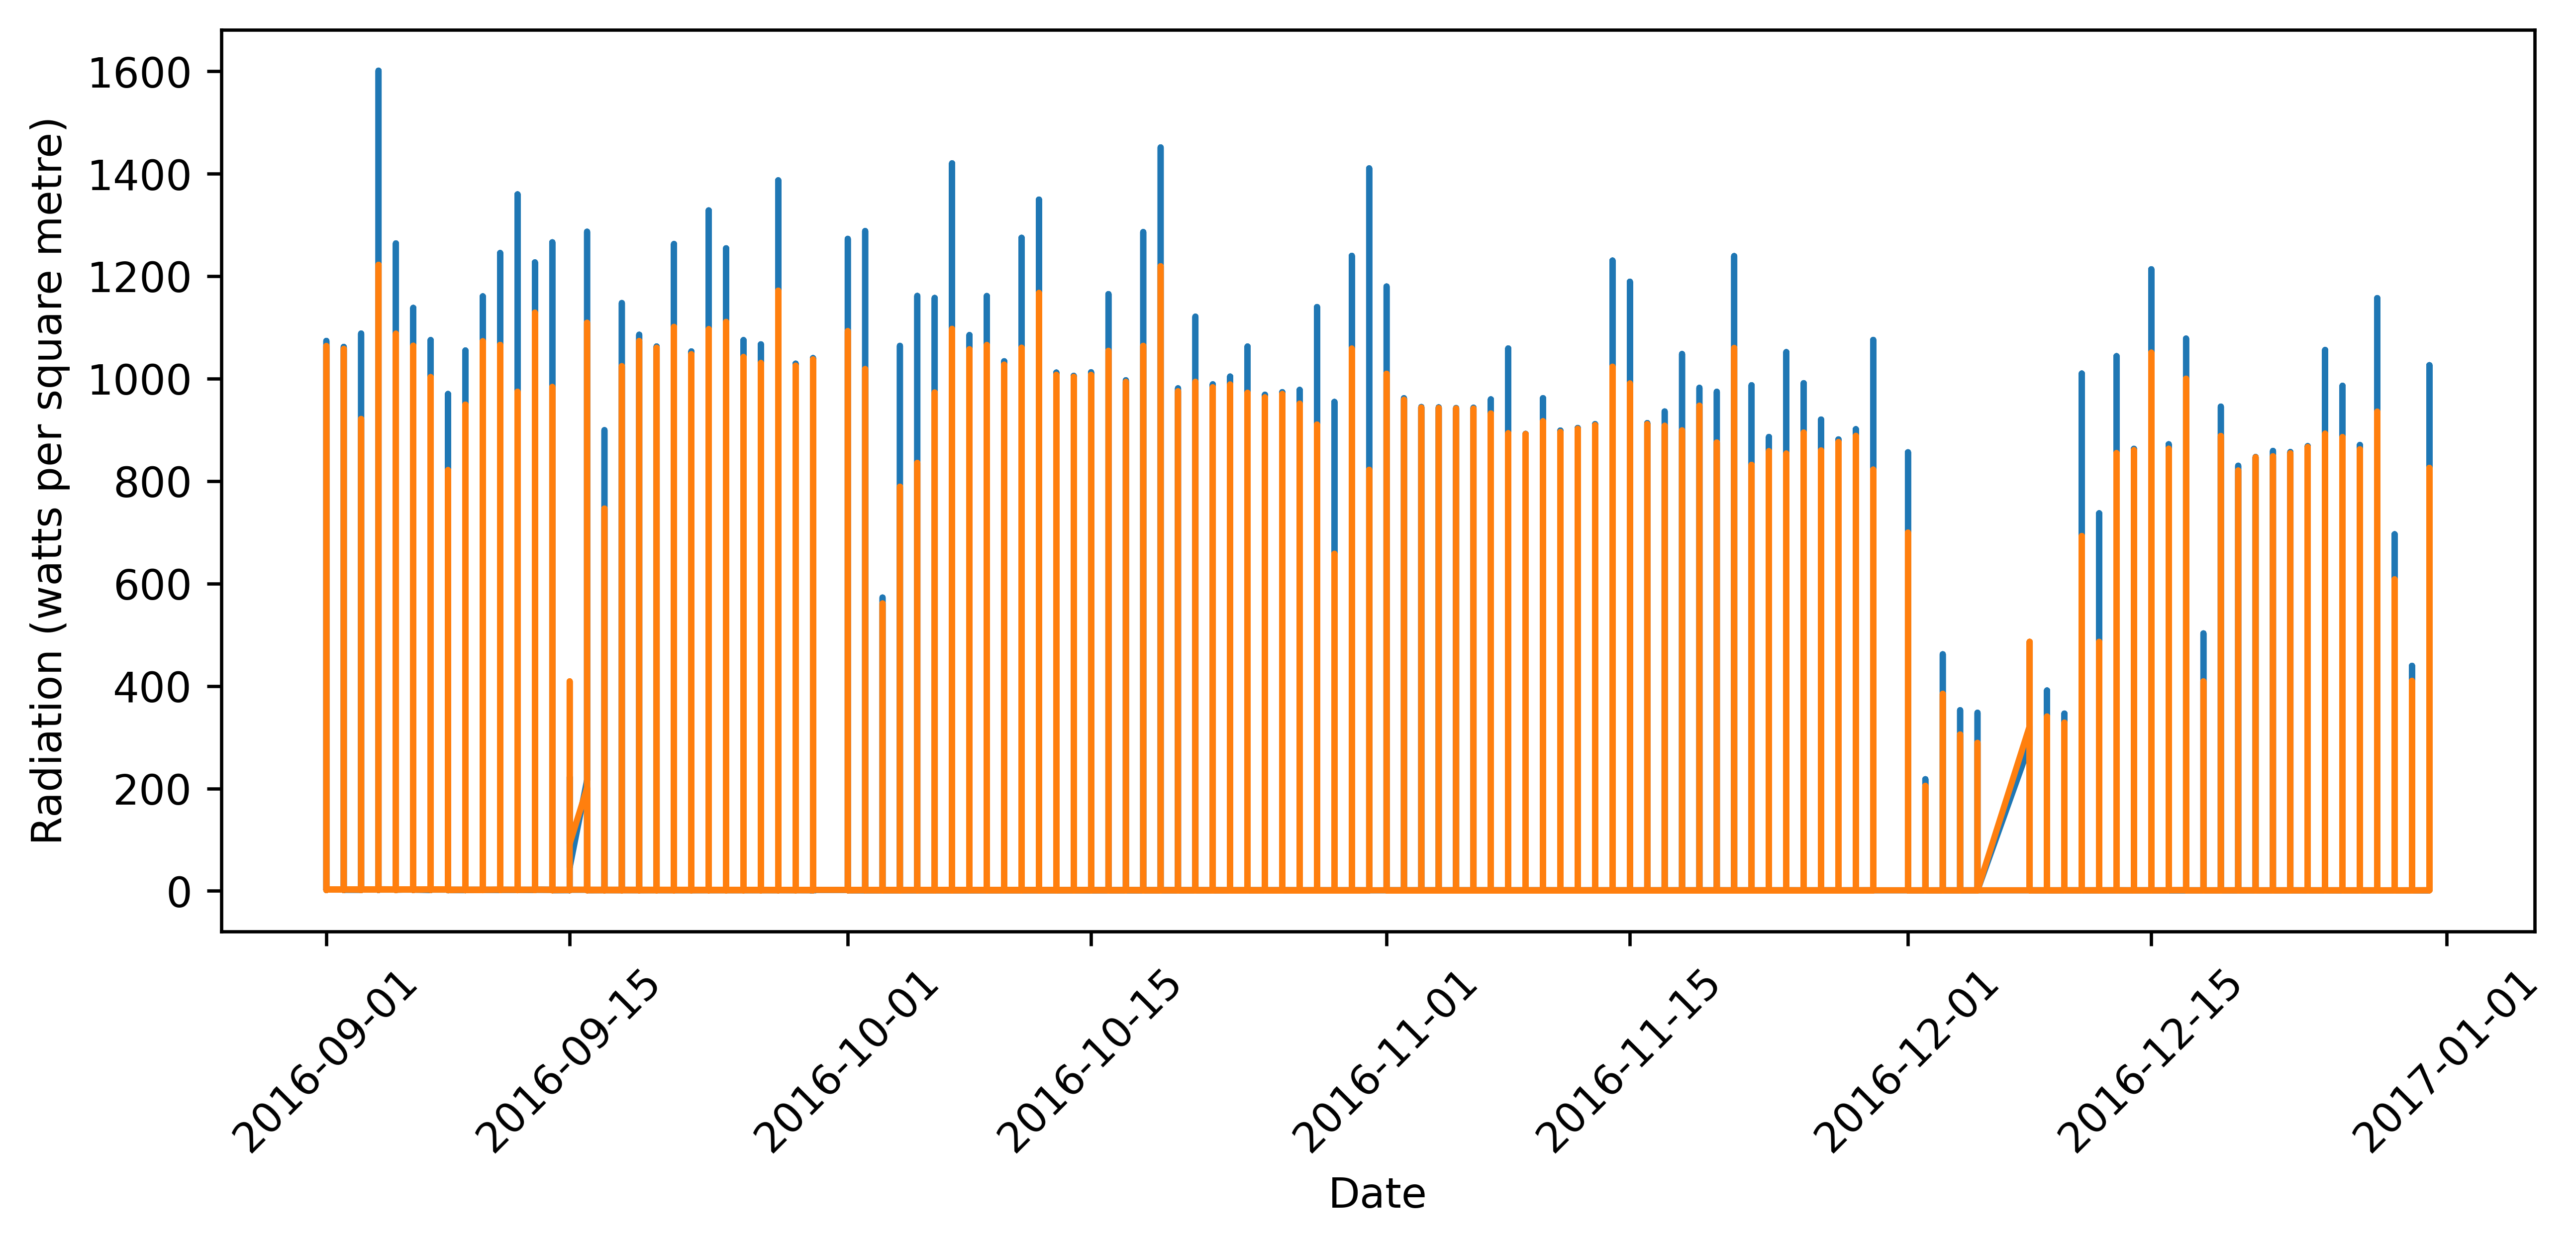

In [30]:
plt.figure(figsize=(10,4),dpi=600)
plt.plot(df.date,df.Radiation)
plt.plot(df.date,best_RF_pred_y)
plt.ylabel('Radiation (watts per square metre)')
plt.xlabel('Date')
_ = plt.xticks(rotation=45)

Text(0.5, 0, 'y_test')

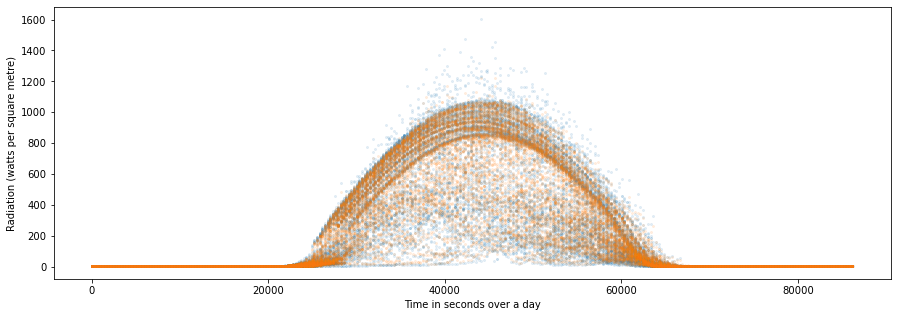

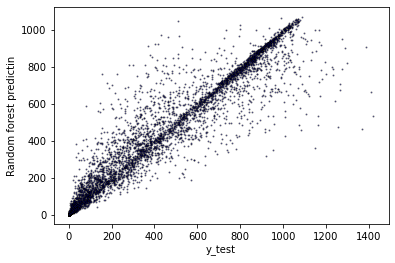

In [31]:
plt.figure(figsize=(15,5))
plt.plot(df.time_in_secs,df.Radiation,
        linestyle='none',
        marker='o',
        alpha=0.1,
        ms=2)
plt.plot(df.time_in_secs,best_RF_pred_y,
        linestyle='none',
        marker='o',
        alpha=0.1,
        ms=2)
plt.ylabel('Radiation (watts per square metre)')
plt.xlabel('Time in seconds over a day')

plt.figure()
plt.plot(y_test,Best_RFR.predict(X_test),
         linestyle ='none',
         marker='o',
         mfc='blue',
         mec='k',
        alpha=0.5,
        ms=1)
plt.ylabel('Random forest predictin')
plt.xlabel('y_test')

The random forest does a much better job at predicting values over 800 w/m2. I'm still a bit unhappy with the models ability to predict really high radiation. I'm going to now try gradient boosting to see if I can do better.

In [32]:
from xgboost import XGBRegressor

In [79]:
XG_trees = XGBRegressor(n_jobs=-1,random_state=42,learning_rate=0.1,n_estimators=250)

In [80]:
XG_trees.fit(X_train,y_train)
XG_trees.score(X_test, y_test)

0.9320851530459058

Text(0.5, 0, 'Date')

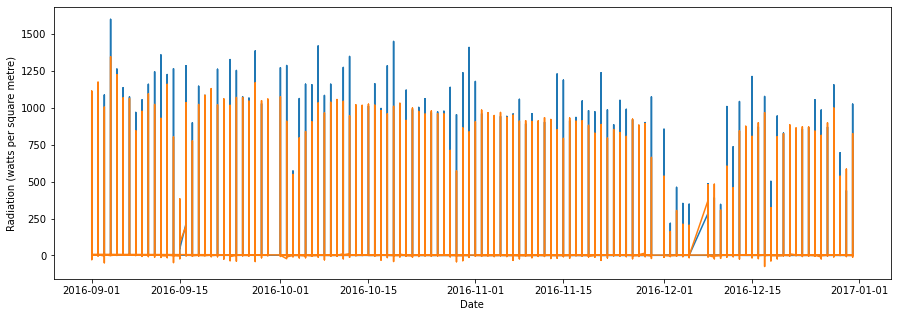

In [90]:
plt.figure(figsize=(15,5))
plt.plot(df.date,df.Radiation)
plt.plot(df.date,XG_trees.predict(scaler.transform(X)))
plt.ylabel('Radiation (watts per square metre)')
plt.xlabel('Date')

The gradient boosted decision trees don't seem to do a better job. Lets try a gradient boosted random forest.

In [33]:
from xgboost import XGBRFRegressor

In [34]:
XGRF_trees = XGBRFRegressor(n_estimators=500, max_depth=100,n_jobs=-1,random_state=42)
XGRF_trees.fit(X_train,y_train)
XGRF_trees.score(X_test, y_test)

0.9352036898359215

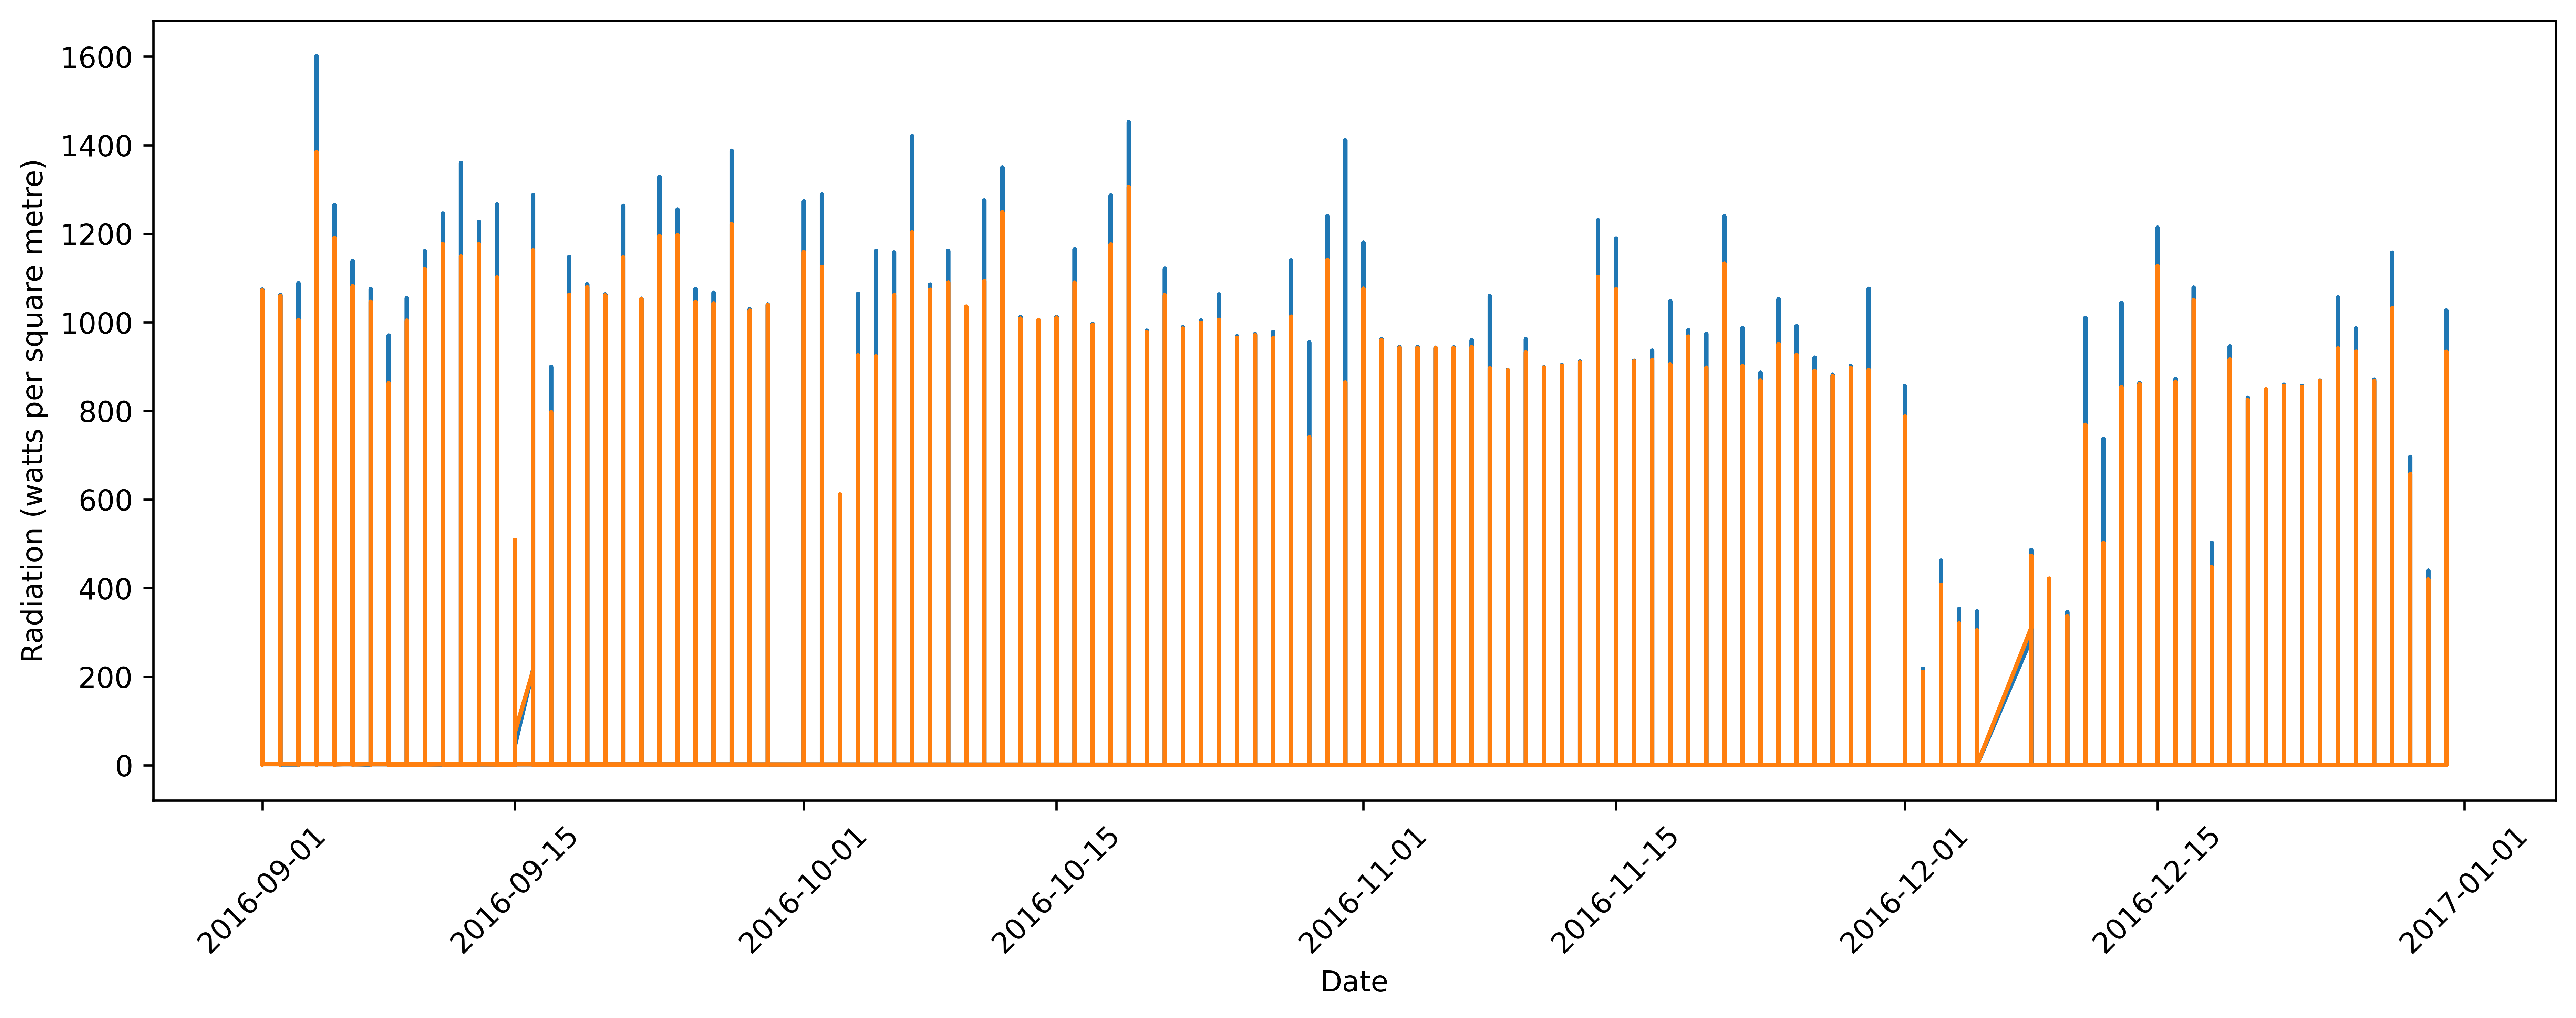

In [37]:
plt.figure(figsize=(15,5),dpi=600)
plt.plot(df.date,df.Radiation)
plt.plot(df.date,XGRF_trees.predict(scaler.transform(X)))
plt.ylabel('Radiation (watts per square metre)')
plt.xlabel('Date')
_ = plt.xticks(rotation=45)

Text(0.5, 0, 'y_test')

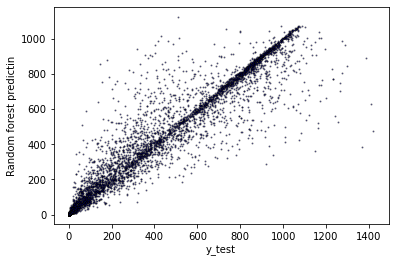

In [82]:
plt.plot(y_test,XGRF_trees.predict(X_test),
         linestyle ='none',
         marker='o',
         mfc='blue',
         mec='k',
        alpha=0.5,
        ms=1)
plt.ylabel('Random forest predictin')
plt.xlabel('y_test')

The gradient boosted random forest has a slightly worse score than the standed RF, however the XGRF does better at predicting the higher values. Overall i'm much happier with this.

Lets check out the most important features. 

In [39]:
feature_importances = XGRF_trees.feature_importances_

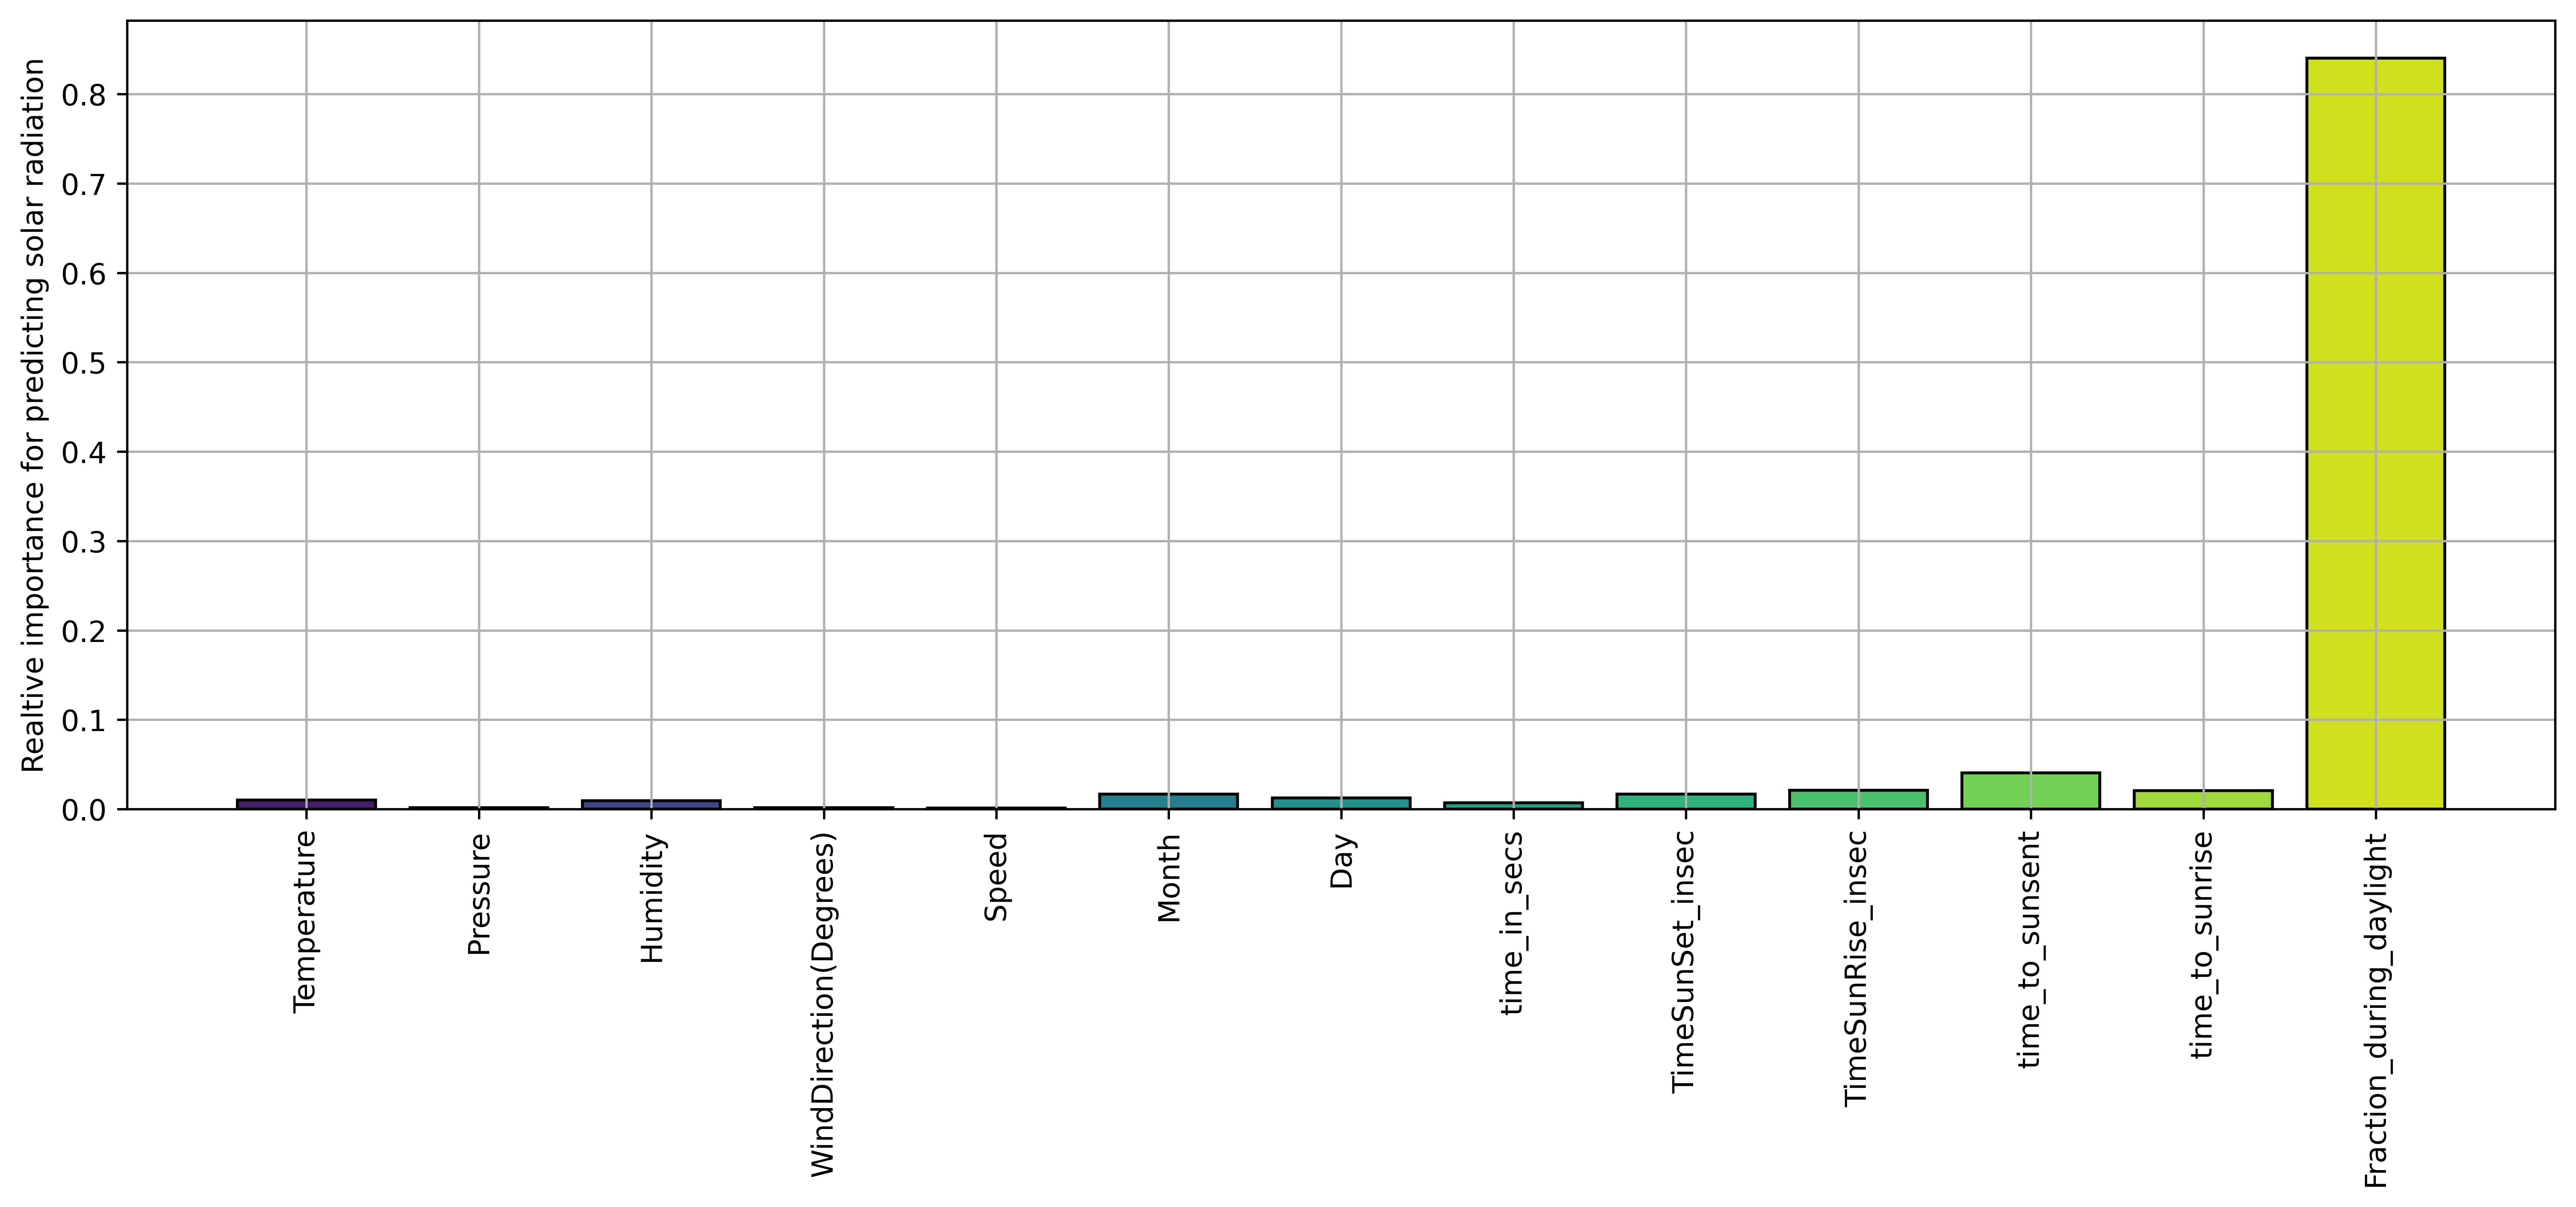

In [40]:
feat_imp = pd.DataFrame(feature_importances,index = df[feats].columns,columns=['Importance'])
plt.figure(figsize=(15,5),dpi=600)
plt.bar(feat_imp.index,feat_imp.Importance,
       color=sns.color_palette('viridis',len(df[feats].columns)),
       edgecolor='k')
_ = plt.xticks(rotation=90)
_ = plt.grid()
_ = plt.ylabel('Realtive importance for predicting solar radiation')

It seems like the most important feature was fraction during daylight hours. This is obviously due to the sun shining more during the day. Month is also important as there is likely more radiation during the summer months. Finally other features like temp and humidity have a minor role, perhapes due to cloud cover etc.